In [6]:
import os
import sys

import numpy as np
import h5py
import matplotlib.pyplot as plt
from skimage import io, transform
from rich.progress import track
import imageio
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

import core

%matplotlib widget



In [ ]:
bse_folder = os.path.join(folder, "BSE/")
key_f = lambda x: int(x.replace(".tif", "").replace("Slice", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tif" in path], key=key_f)
# bse = np.array([io.imread(path, as_gray=True) for path in paths])
bse = io.imread(paths[0], as_gray=True)
dy = 4050
dx = 4212
slice_y = slice(int(bse.shape[0] / 2 - dy / 2) - 23, int(bse.shape[0] / 2 + dy / 2) - 23)
slice_x = slice(int(bse.shape[1] / 2 - dx / 2) + 100, int(bse.shape[1] / 2 + dx / 2) + 100)


In [ ]:
global_shift = 0
for i in range(len(paths)):
    im = io.imread(paths[i], as_gray=True)
    if i+1 > 212:
        out = np.zeros(im.shape, dtype=im.dtype)
        out[:, 355:] = im[:, :-355]
    else:
        out = im
    if i % 4 == 0:
        global_shift += 1
    if global_shift > 0:
        out[:, :-global_shift] = out[:, global_shift:]
    imageio.imsave(f"D:/Research/Ta_AM-Spalled/Data/3D/BSE/cropped/{i+1}.tiff", out[slice_y, slice_x])

In [ ]:
ebsd_shape = h5py.File(os.path.join(folder, "Ta_AM-Spalled_aligned.dream3d"))["DataContainers/ImageDataContainer/CellData/Image Quality"].shape[1:3]
print(ebsd_shape)

bse_folder = os.path.join(folder, "BSE/cropped/")
key_f = lambda x: int(x.replace(".tiff", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tiff" in path], key=key_f)

for i in range(len(paths)):
    raw = io.imread(paths[i], as_gray=True)
    d = transform.resize(raw, ebsd_shape)
    d = np.around(65535 * d/d.max(), 0).astype(np.uint16)
    imageio.imsave(os.path.join(folder, f"BSE/small/{i}.tiff"), d, format="TIFF")


In [ ]:
s = 200
key = "Phases"
ebsd = h5py.File(os.path.join(folder, "CoNi16_aligned_corrected.dream3d"), "r")
cell_s = "DataContainers/ImageDataContainer/CellData/"
plt.close("all")
phases = ebsd[cell_s+key][...]
im = phases[100]
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax1.imshow(im)
plt.show()
# ebsd[cell_s+key][...] = phases
ebsd.close()

### INSERTING BSE INTO EBSD

In [ ]:
folder = "D:/Research/CoNi_TFS/Data/3D/"
# Read EBSD in
ebsd = h5py.File(os.path.join(folder, "CoNi90.dream3d"), "r+")
cell_s = "DataContainers/ImageDataContainer/CellData/"
# Read BSE in
bse_folder = os.path.join(folder, "BSE/small/")
key_f = lambda x: int(x.replace(".tiff", "").replace(bse_folder, ""))
bse_paths = os.listdir(bse_folder)
paths = sorted([os.path.join(bse_folder, path) for path in bse_paths if ".tiff" in path], key=key_f)
bse = np.array([io.imread(path, as_gray=True) for path in paths])# .reshape(ebsd[cell_s+"IQS"].shape)

bse = bse[:, bse.shape[1]-438:, :1052]
ci = np.squeeze(ebsd[cell_s+"IQS"][...])
# bse_ebsd = ebsd[cell_s+"BSE"][...]
# bse_ebsd[:, :, :, 0] = bse
# ebsd[cell_s+"BSE"][...] = bse_ebsd

bad_slices = [198, 228, 265]

for index in bad_slices:
    im = np.zeros(bse.shape[1:], dtype=bse.dtype)
    x = np.delete(np.arange(index - 3, index + 4, 1), 3)
    for i in range(bse.shape[1]):
        for j in range(bse.shape[2]):
            y = np.delete(bse[index-3:index+4, i, j], 3)
            f = interp1d(x, y)
            im[i, j] = f(index)

    bse[index] = im
    

core.interactive_overlay(ci[198], bse[198])

In [ ]:

ebsd[cell_s+"BSE"][...] = bse.reshape(*bse.shape, 1)

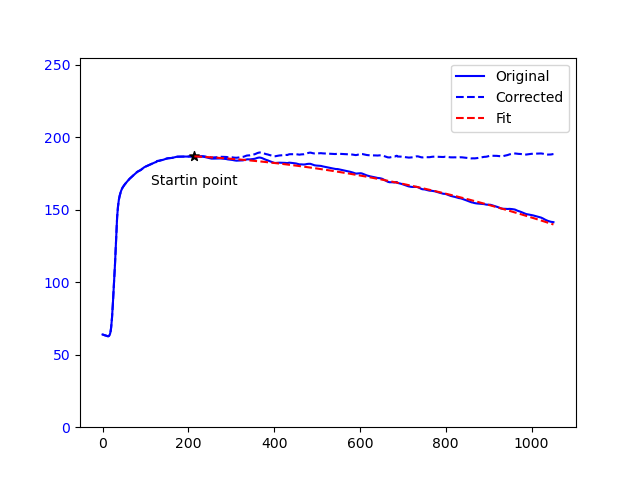

In [50]:
folder = "D:/Research/CoNi_TFS/Data/3D/"
ebsd = h5py.File(os.path.join(folder, "CoNi90.dream3d"), "r+")
cell_s = "DataContainers/ImageDataContainer/CellData/"
bse = np.squeeze(ebsd[cell_s+"BSE"][...])
y = bse.mean(axis=(0, 1))
x = np.arange(y.shape[0])

x_fit = x[y.argmax():]
y_fit = y[y.argmax():]
def f(x, a, b, c):
    return a*x**2 + b*x + c
popt, _ = curve_fit(f, x_fit, y_fit)

diff =  y.max() - f(x_fit, *popt)
diff = diff - diff.min()

y_new = np.copy(y)
y_new[y_new.argmax():] += diff

y_fit_new = f(x_fit, *popt)
y_fit_new = y_fit_new - (y_fit_new[0] - y.max())

plt.close(101)
fig, ax = plt.subplots(num=101, nrows=1, ncols=1)
ax.plot(x, y, 'b', label='Original', zorder=0)
ax.plot(x, y_new, 'b--', label="Corrected", zorder=1)
ax.plot(x_fit, y_fit_new, 'r--', label="Fit")
ax.tick_params(axis='y', labelcolor='b')
ax.set_ylim(0, 255)
ax.scatter(y.argmax(), y.max(), s=50, marker='*', c='k')
ax.text(y.argmax(), y.max() - 20, "Startin point", ha='center', zorder=3)
ax.legend()
plt.show()

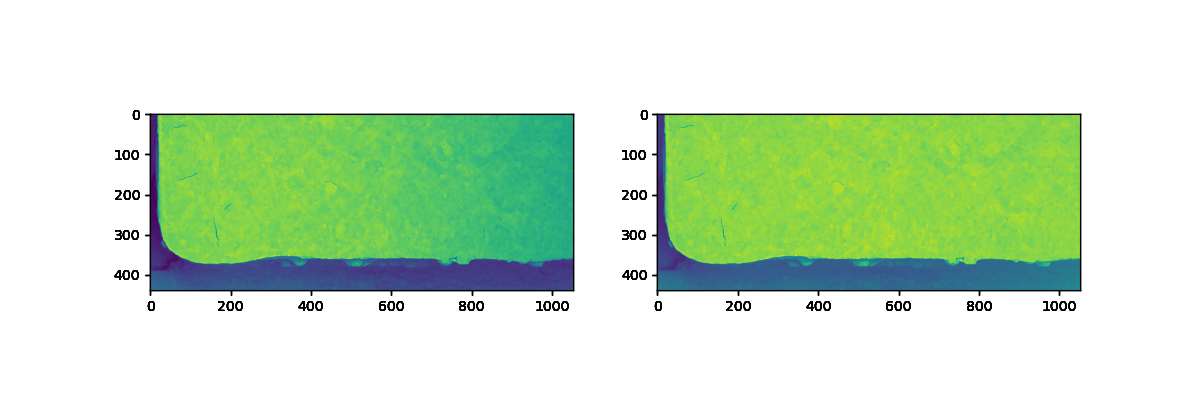

In [57]:

bse_new = np.copy(bse)
bse_new[:, :, y.argmax():] += diff.astype(np.uint8)

ebsd[cell_s+"BSE"][...] = bse_new.reshape(*bse_new.shape, 1)

fig, (ax1, ax2) = plt.subplots(1, 2, num=10101, figsize=(12,4))
ax1.imshow(bse[0])
ax2.imshow(bse_new[0])
plt.show()